In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns
import statistics
from meegkit import dss

from pycrostates.preprocessing import extract_gfp_peaks
from proof_of_consept import unit_normalize
from neurokit2.microstates.microstates_clean import microstates_clean
from mne_icalabel import label_components
from scipy.stats import kurtosis, skew

In [2]:
def zapline_clean(raw, fline):
    data = raw.get_data().T # Convert mne data to numpy darray
    sfreq = raw.info['sfreq'] # Extract the sampling freq
   
    #Apply MEEGkit toolbox function
    out, _ = dss.dss_line(data, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    print(out.shape)

    cleaned_raw = mne.io.RawArray(out.T, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [3]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\epilepsy_data")
file = data_folder / "TLE_0010.bdf"

raw = mne.io.read_raw_bdf(file, verbose=False, preload=False)
raw.crop(tmin=100, tmax=200).load_data()
print(raw.info['ch_names'])
raw.drop_channels(['SO2', 'IO2', 'LO1', 'LO2', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status'])
#Be carefull that artifact electrodes are not included in the average calc.
mne.set_eeg_reference(raw, copy=False, verbose=False)
#Be carefull that artifact electrodes are not included in the average calc.
print(raw.info)
raw.set_montage('biosemi128')
#raw.drop_channels('O2')#raw.info["bads"].append("O2")
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#raw.set_montage('biosemi64')

#bridged, dist = mne.preprocessing.compute_bridged_electrodes(raw)


raw_highpass = raw.copy().filter(l_freq=1, h_freq=None, verbose=False)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=100, verbose=False)
line_noise = zapline_clean(raw_lowpass, 50)
raw_down_sampled = line_noise.copy().resample(sfreq=300, verbose=False)

Reading 0 ... 204800  =      0.000 ...   100.000 secs...
['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32', 'SO2', 'IO2', 'LO1', 'LO2', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
<Info | 9 no

[PCA] Explained variance of selected components : 27.15%
Power of components removed by DSS: 0.15
(204801, 128)
Creating RawArray with float64 data, n_channels=128, n_times=204801
    Range : 0 ... 204800 =      0.000 ...   100.000 secs
Ready.


In [4]:
print(raw_down_sampled.get_data().shape)

(128, 30000)


In [5]:
def gfp_normed_diss_data(indices, data, gfp):
    all_inx = np.arange(data.shape[1])
    unorderd_adj_indices = np.array([indices, (indices-1)]).flatten()
    anti_adj_indices = np.delete(all_inx, unorderd_adj_indices)
    all_inx = np.arange(data.shape[1])
    adj_indices = np.delete(all_inx, anti_adj_indices)

    indexed_data = data[:, adj_indices]
    indexed_gfp = gfp[adj_indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

def gfp_normed_diss_data2(indices, data, gfp):
    indexed_data = data[:, indices]
    indexed_gfp = gfp[indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

In [6]:
def diss(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices), data.shape[0]))
    for t in range(0, len(indices)*2, 2):
        diss[int(t/2), :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t+1])
    return diss

def diss2(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data2(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices)-1, data.shape[0]))
    for t in range(1, len(indices)):
        diss[t-1, :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t-1])
    return diss

In [7]:
def epoched_stability1(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stabilty = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        d = diss(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stabilty[e] = np.mean(for_convex)
    return stability, convex_stabilty

def epoched_stability2(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stability = np.ndarray(shape=(epochs_array.shape[0]))
    switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    significant_switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    peaks = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        if e == 0:
            data_at_peaks = data[:, indices]
            full_data = data
        else:
            data_at_peaks = np.concatenate((data_at_peaks, data[:, indices]), axis=1)
            full_data = np.concatenate((full_data, data), axis=1)
        d = diss2(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        freq = 0
        sfreq = 0
        for s in individual_map_stability:
            if s > 0:
                freq += 1
            if s > 0.4:
                sfreq += 1
        switching_freq[e] = freq
        significant_switching_freq[e] = sfreq
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stability[e] = np.mean(for_convex)
        peaks[e] = len(indices)
    return stability, switching_freq, convex_stability, significant_switching_freq, peaks, full_data, data_at_peaks

Bad epoch idenfication - based on topographic stability

Between GFP peaks

In [8]:
ones_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, overlap=0.5)

In [9]:
print(ones_epochs.get_data().shape)

Using data from preloaded Raw for 199 events and 300 original time points ...
0 bad epochs dropped
(199, 128, 300)


In [10]:
epoched_stability, epoched_switching_freq, convex_stabilty, significant_switching_freq, peaks, _, _ = epoched_stability2(ones_epochs)

Using data from preloaded Raw for 199 events and 300 original time points ...


Plots to investigate exclusion of epocs not following our assumptions.

Epoch averaged DISS

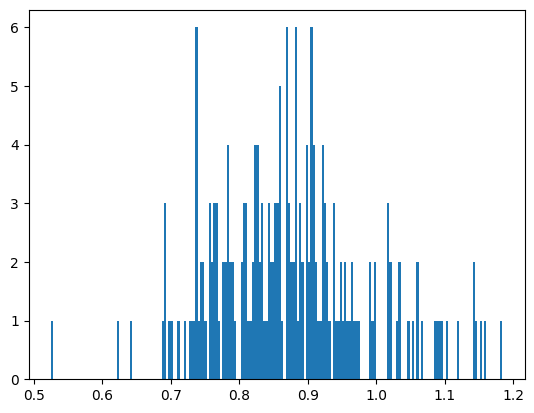

In [11]:
plt.hist(convex_stabilty, bins=200)
plt.show()

In [12]:
timepoints = np.where(convex_stabilty<0)[0]
print((timepoints)/2)

[]


Stability transformed: absoluteDISS = |DISS-1| ... and averaged for each epoch. Now only high values indicate stability.

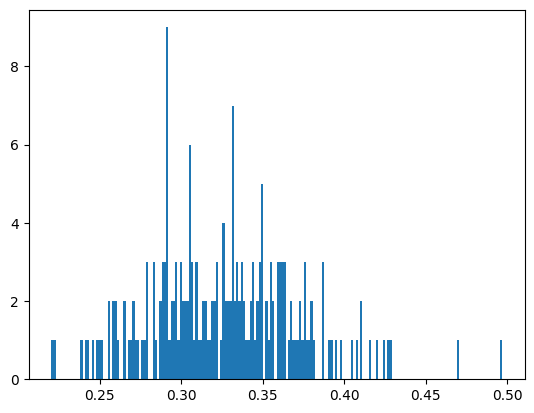

In [13]:
plt.hist(epoched_stability, bins=200)
plt.show()

In [14]:
timepoints = np.where(epoched_stability<0)[0]
print((timepoints)/2)

[]


Average epoch polarity inversion going from gfp peak to gfp peak, meaning DISS < 1.

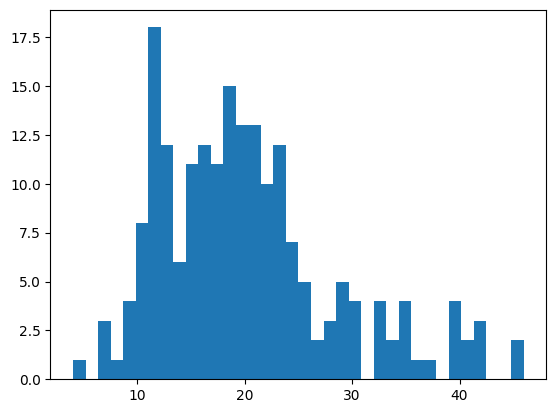

In [15]:
plt.hist(epoched_switching_freq, bins=36)
plt.show()

In [16]:
timepoints = np.where(epoched_switching_freq>300)[0]
print((timepoints)/2)

[]


The same again, but only for shifts in polarity where higher stability is indicated (DISS > 1.4)

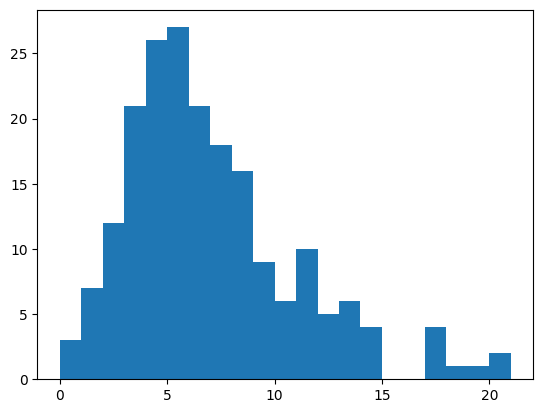

In [17]:
plt.hist(significant_switching_freq, bins=21)
plt.show()

In [18]:
timepoints = np.where(significant_switching_freq==-1)[0]
print((timepoints)/2)

[]


Number of GFP peaks for each epoch

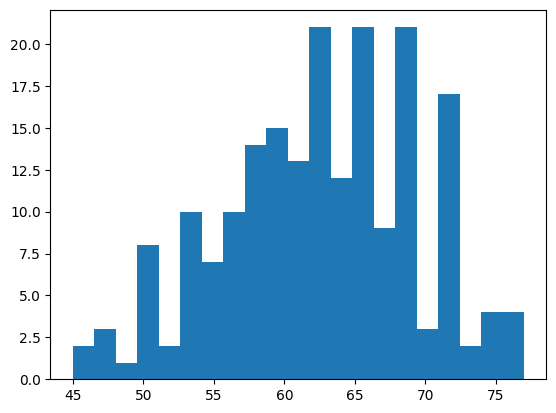

In [19]:
plt.hist(peaks, bins=21)
plt.show()

In [20]:
timepoints = np.where(peaks>500)[0]
print((timepoints)/2)

[]


Looking at scatter plot between swithcing frequencies and number of GFP peaks

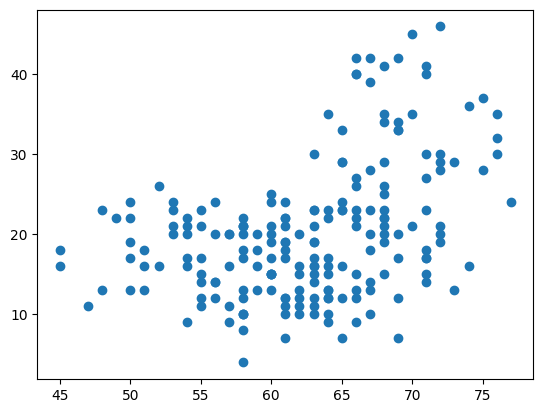

In [21]:
plt.scatter(peaks, epoched_switching_freq)
plt.show()

In [22]:
idx = np.where((epoched_switching_freq < 0))[0]
print((idx-1)/2)

[]


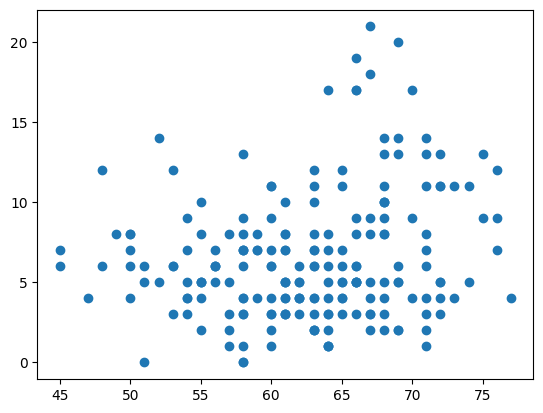

In [23]:
plt.scatter(peaks, significant_switching_freq)
plt.show()

In [24]:
idx = np.where((peaks > 57))[0]
print(idx)
print((idx-1)/2)

idx = np.where((peaks < 28) & (significant_switching_freq < 9))[0]
print((idx-1)/2)

idx = np.where((significant_switching_freq == 0))[0]
print((idx-1)/2)

[  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  54  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  75  76  77  78
  79  80  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 156 157 158 159 160 161 164 165 166 176 179 180]
[-0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.
 21.5 22.  22.5 23.  23.5 24.  24.5 25.  26.5 28.  28.5 29.  29.5 30.
 30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  37.  37.5
 38.  38.5 39

Looking at average absoluteDISS in relation to switching frequencies.

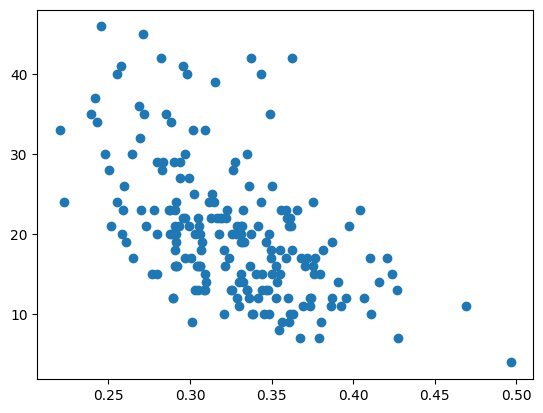

In [25]:
plt.scatter(epoched_stability, epoched_switching_freq)
plt.show()

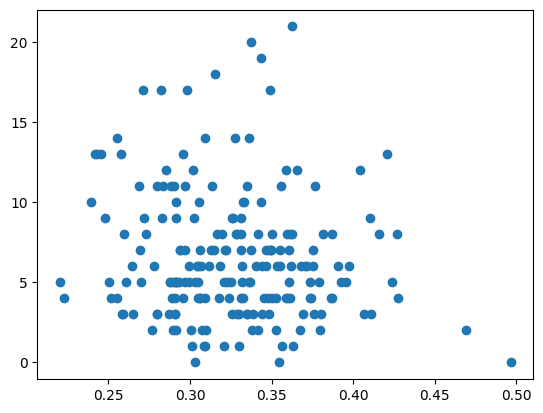

In [26]:
plt.scatter(epoched_stability, significant_switching_freq)
plt.show()

In [27]:
idx = np.where((epoched_stability > 10.5) & (significant_switching_freq < 5))[0]
print((idx-1)/2)

[]


Same but with average DISS

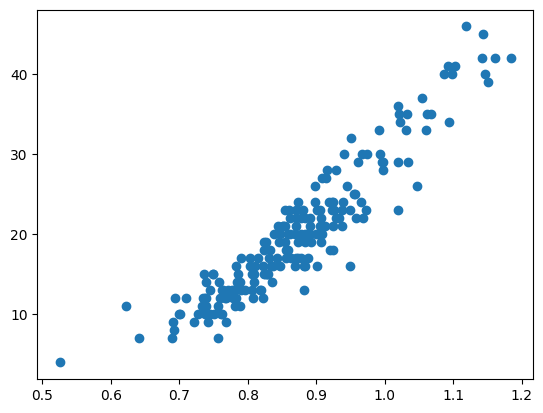

In [28]:
plt.scatter(convex_stabilty, epoched_switching_freq)
plt.show()

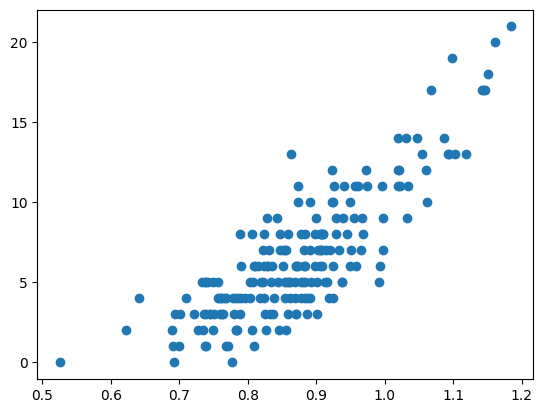

In [31]:
plt.scatter(convex_stabilty, significant_switching_freq)
plt.show()

Scatter of the two stability types

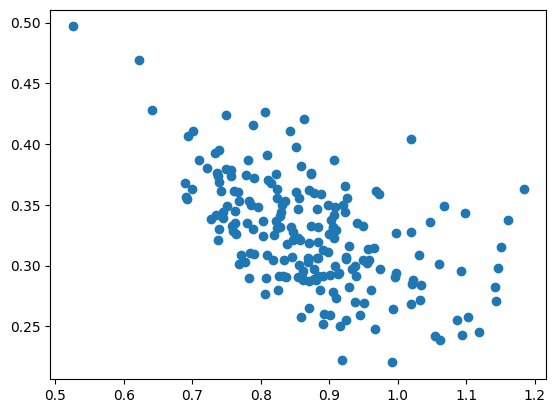

In [32]:
plt.scatter(convex_stabilty, epoched_stability)
plt.show()

In [33]:
idx = np.where((epoched_stability>10.6) & (convex_stabilty<0.75))[0]
print(idx)
print((idx)/2)

[]
[]


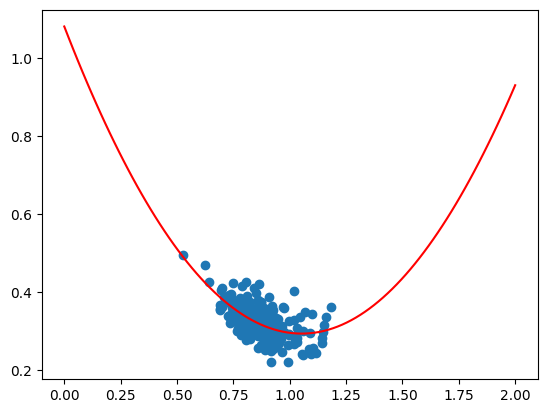

In [34]:
fit = np.poly1d(np.polyfit(convex_stabilty, epoched_stability, 2))
polyline = np.linspace(0, 2, 100)
plt.scatter(convex_stabilty, epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.show()


In [35]:
print(fit)

        2
0.7101 x - 1.496 x + 1.082


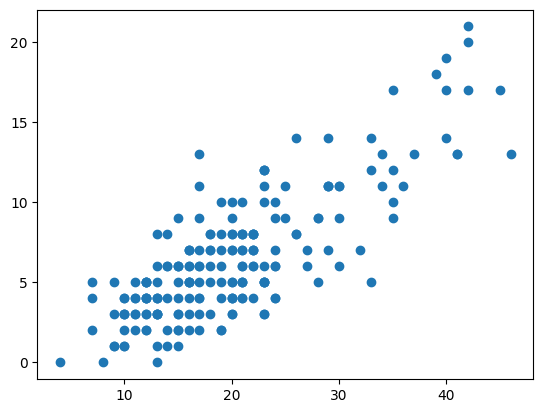

In [36]:
plt.scatter(epoched_switching_freq, significant_switching_freq)
plt.show()

In [37]:
idx = np.where((epoched_switching_freq > 250) & (significant_switching_freq < 15))[0]
print((idx-1)/2)

[]


In [38]:
channel_names = np.array(raw_down_sampled.info['ch_names'])

At GFP peaks

In [39]:
at_epoched_stability, at_convex_stabilty = epoched_stability1(ones_epochs)

Using data from preloaded Raw for 199 events and 300 original time points ...


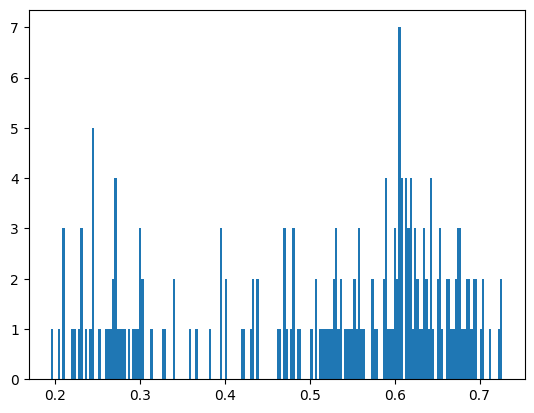

In [40]:
plt.hist(at_epoched_stability, bins=200)
plt.show()

In [41]:
idx = np.where(at_epoched_stability > 10.85)[0]
print((idx-1)/2)
idx = np.where(at_epoched_stability < 0.04)[0]
print((idx-1)/2)

[]
[]


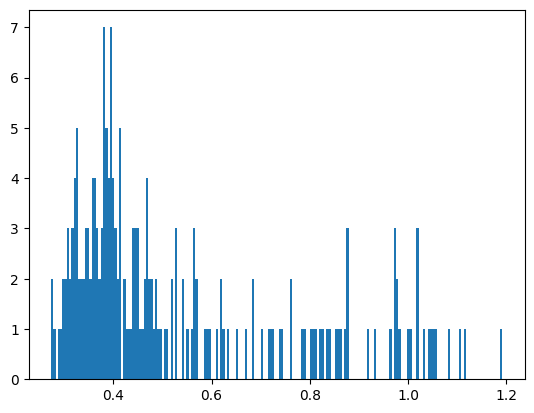

In [42]:
plt.hist(at_convex_stabilty, bins=200)
plt.show()

In [43]:
idx = np.where(at_convex_stabilty > 10.8)[0]
print((idx-1)/2)
idx = np.where(at_convex_stabilty < 0.015)[0]
print((idx-1)/2)

[]
[]


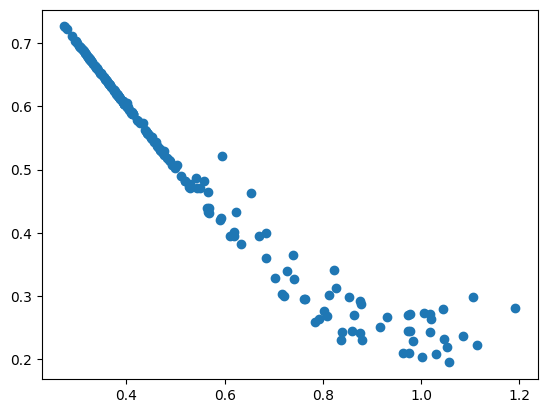

In [44]:
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.show()

In [45]:
idx = np.where((at_convex_stabilty > 10.8) & (at_epoched_stability < 0.04))[0]
print((idx-1)/2)

[]


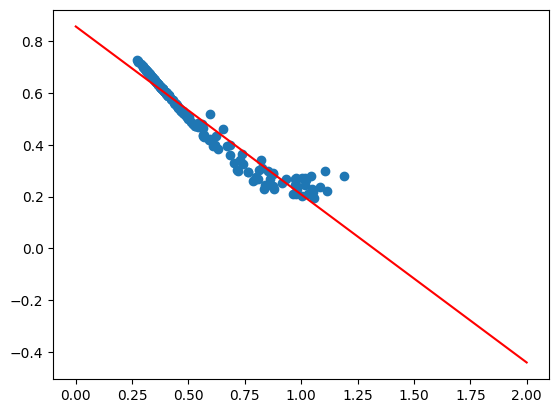

In [46]:
fit = np.poly1d(np.polyfit(at_convex_stabilty, at_epoched_stability, 1))
polyline = np.linspace(0, 2, 100)
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.show()

In [47]:
print(fit)

 
-0.6496 x + 0.8579


The median prinsipal for channel stability and pca heuristic analysis

In [48]:
idx = np.where((epoched_stability>=np.median(epoched_stability)) & (convex_stabilty>=np.median(convex_stabilty)) & (at_epoched_stability > np.median(at_epoched_stability)))[0]
print(idx)

[ 49  50  74 155 163 164 167 170 171 172 188 189 193 194]


In [49]:
print(channel_names)

['A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'A10' 'A11' 'A12' 'A13'
 'A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A21' 'A22' 'A23' 'A24' 'A25'
 'A26' 'A27' 'A28' 'A29' 'A30' 'A31' 'A32' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6'
 'B7' 'B8' 'B9' 'B10' 'B11' 'B12' 'B13' 'B14' 'B15' 'B16' 'B17' 'B18'
 'B19' 'B20' 'B21' 'B22' 'B23' 'B24' 'B25' 'B26' 'B27' 'B28' 'B29' 'B30'
 'B31' 'B32' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11'
 'C12' 'C13' 'C14' 'C15' 'C16' 'C17' 'C18' 'C19' 'C20' 'C21' 'C22' 'C23'
 'C24' 'C25' 'C26' 'C27' 'C28' 'C29' 'C30' 'C31' 'C32' 'D1' 'D2' 'D3' 'D4'
 'D5' 'D6' 'D7' 'D8' 'D9' 'D10' 'D11' 'D12' 'D13' 'D14' 'D15' 'D16' 'D17'
 'D18' 'D19' 'D20' 'D21' 'D22' 'D23' 'D24' 'D25' 'D26' 'D27' 'D28' 'D29'
 'D30' 'D31' 'D32']


In [50]:
channelstab_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, duration=0.5)

In [51]:
anti_idx = np.arange(480)
anti_idx = np.delete(anti_idx, idx)
print(anti_idx)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 156 157 158 159 160 161 162 165 166 168
 169 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 190 191
 192 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255 256 257 258 259 26

In [52]:
#channelstab_epochs.drop(anti_idx)

In [53]:
def remove_bad(mne_epoch_object, channel_name):
    raw = mne_epoch_object.copy()
    raw.drop_channels(channel_name)
    return raw

In [54]:
def leav_one_out(epochs_object):
    epoched_stability, _, _, _, _, _, _ = epoched_stability2(epochs_object)
    ch_name_list = epochs_object.info['ch_names']
    basline_stability = np.mean(epoched_stability)
    stability_change = np.ndarray(shape=(len(ch_name_list)))
    for c in range(len(ch_name_list)):
        instance = remove_bad(epochs_object, ch_name_list[c])
        stab, _, _, _, _, _, _ = epoched_stability2(instance)
        stability_change[c] = basline_stability - np.mean(stab)        
    return stability_change

In [55]:
def leav_one_out2(epochs_object):
    epoched_stability, _ = epoched_stability1(epochs_object)
    ch_name_list = epochs_object.info['ch_names']
    basline_stability = np.mean(epoched_stability)
    stability_change = np.ndarray(shape=(len(ch_name_list)))
    for c in range(len(ch_name_list)):
        instance = remove_bad(epochs_object, ch_name_list[c])
        stab, _ = epoched_stability1(instance)
        stability_change[c] = basline_stability - np.mean(stab)        
    return stability_change

In [56]:
#channelstab_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, duration=0.5)
at_test1 = leav_one_out2(channelstab_epochs)
#channelstab_epochs.drop([100, 101, 102, 108, 109, 110, 111])
test1 = leav_one_out(channelstab_epochs)

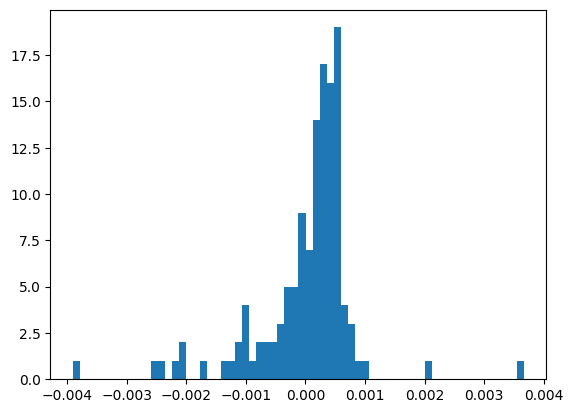

In [57]:
plt.hist(at_test1, bins=64)
plt.show()

In [58]:
order = np.argsort(at_test1)
print(channel_names[order])

['D24' 'D21' 'D31' 'D22' 'C30' 'C31' 'D20' 'D30' 'D32' 'D10' 'D19' 'D9'
 'D8' 'D26' 'D25' 'D23' 'B25' 'B26' 'B29' 'D29' 'D12' 'D11' 'B9' 'C14'
 'B1' 'D5' 'D7' 'A9' 'D27' 'A7' 'A26' 'A8' 'B30' 'D18' 'A6' 'D6' 'C11'
 'C29' 'C32' 'D4' 'D28' 'A27' 'B32' 'C9' 'B16' 'B3' 'B11' 'B19' 'C4' 'B14'
 'A17' 'C1' 'D17' 'C21' 'A16' 'D15' 'B17' 'A25' 'B22' 'D16' 'B10' 'C2'
 'B12' 'C23' 'A28' 'A5' 'B4' 'C13' 'B20' 'A31' 'B8' 'A10' 'A4' 'B5' 'A18'
 'B6' 'D3' 'D14' 'C22' 'A14' 'C28' 'C10' 'C24' 'A29' 'B2' 'A15' 'A11'
 'B24' 'A13' 'C20' 'A32' 'C8' 'C12' 'A23' 'D2' 'C18' 'A12' 'B23' 'B31'
 'B28' 'C26' 'B18' 'A20' 'A22' 'C17' 'A30' 'A1' 'A3' 'A24' 'D13' 'C25'
 'A21' 'C16' 'B7' 'A19' 'C19' 'A2' 'B13' 'B15' 'C5' 'C3' 'C27' 'D1' 'C7'
 'C6' 'C15' 'B27' 'B21']


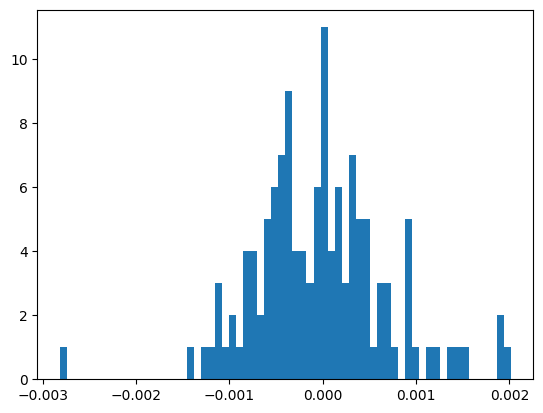

In [59]:
plt.hist(test1, bins=64)
plt.show()

In [60]:
order = np.argsort(test1)
print(channel_names[order])

['B31' 'D27' 'D24' 'B3' 'C30' 'D32' 'B19' 'C31' 'B21' 'D28' 'C6' 'B1'
 'D16' 'B5' 'D19' 'C18' 'C15' 'B10' 'B25' 'A11' 'B28' 'B32' 'C11' 'B29'
 'D20' 'C1' 'C3' 'A4' 'B13' 'A2' 'A6' 'A32' 'A7' 'C17' 'C21' 'C2' 'B26'
 'A31' 'B17' 'D30' 'A5' 'A8' 'A17' 'B4' 'A3' 'D31' 'B24' 'B22' 'D26' 'D15'
 'C28' 'C9' 'C14' 'C20' 'C16' 'A10' 'A12' 'B30' 'A1' 'B14' 'D29' 'B11'
 'B16' 'A18' 'B15' 'A30' 'D23' 'C8' 'B23' 'A9' 'D25' 'A20' 'C7' 'C12'
 'C10' 'B18' 'A19' 'A29' 'C24' 'D18' 'B6' 'B2' 'A16' 'A14' 'B27' 'D1'
 'C13' 'B20' 'C22' 'C29' 'A27' 'A13' 'C5' 'C23' 'B9' 'A28' 'A21' 'B12'
 'C19' 'C4' 'D2' 'C26' 'C27' 'A15' 'D6' 'D17' 'B8' 'A23' 'D14' 'A22' 'B7'
 'D7' 'A25' 'D13' 'C25' 'D11' 'D12' 'C32' 'A26' 'D4' 'A24' 'D3' 'D22' 'D8'
 'D5' 'D9' 'D10' 'D21']


In [61]:
print(kurtosis(test1))
print(skew(test1))

1.6554365957590544
0.11105923718495185


PCA heuristic idea

In [62]:
print(ones_epochs.get_data().shape)
print(channelstab_epochs.get_data().shape)

Using data from preloaded Raw for 199 events and 300 original time points ...
(199, 128, 300)
(200, 128, 150)


In [63]:
_, _, _, _, _, data_all, data_at_peaks = epoched_stability2(channelstab_epochs)

In [64]:
data = data_at_peaks.T

In [65]:
scaler = sklearn.preprocessing.StandardScaler()
data = scaler.fit_transform(data)

In [66]:
def pca_auc(data):
    pca = sklearn.decomposition.PCA(random_state=9)
    pca.fit_transform(data)
    roc_curve = np.ndarray(shape=pca.components_.shape[0])
    explained_var = pca.explained_variance_ratio_
    percent = 0
    for v in range(roc_curve.shape[0]):
        percent += explained_var[v]
        roc_curve[v] = percent
    auc = np.trapz(roc_curve.flatten())
    return auc/pca.components_.shape[0], roc_curve

0.9414713110289651


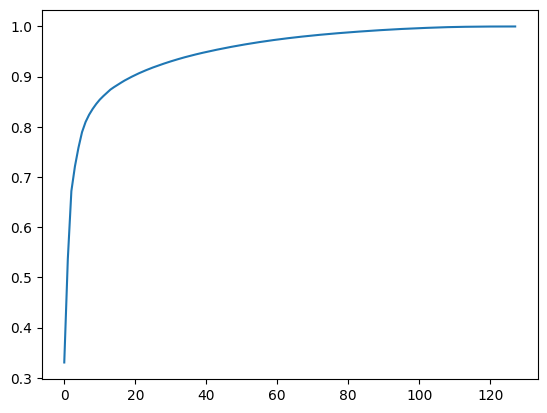

In [67]:
benchmark, rc = pca_auc(data)
print(benchmark)
plt.plot(rc)
plt.show()

In [68]:
pc_all_chanels = np.ndarray(128)
for c in range(len(channel_names)):
    dataaa = np.delete(data, c, axis=1)
    b, r = pca_auc(dataaa)
    pc_all_chanels[c] = b-benchmark

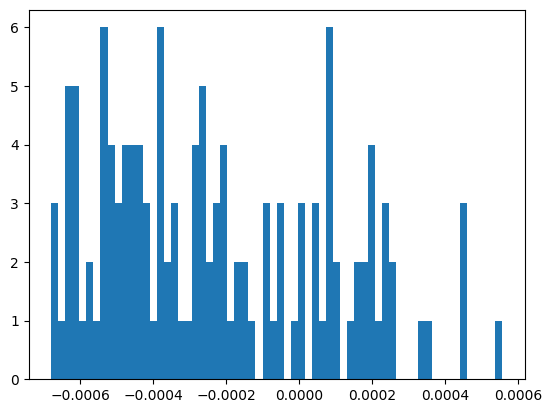

In [69]:
plt.hist(pc_all_chanels, bins=64)
plt.show()

In [70]:
order = np.argsort(pc_all_chanels)
print(channel_names[order])

['A11' 'A10' 'A12' 'C26' 'A22' 'A20' 'A21' 'A16' 'A15' 'D10' 'D9' 'A27'
 'D8' 'A28' 'C19' 'C10' 'A13' 'A2' 'A1' 'C23' 'A9' 'A23' 'A14' 'D15' 'A29'
 'D6' 'A24' 'D7' 'C30' 'D11' 'D12' 'C13' 'A26' 'B7' 'D4' 'C2' 'C20' 'C1'
 'C31' 'A25' 'A30' 'C32' 'D3' 'D18' 'D14' 'A3' 'A17' 'D29' 'D5' 'A6' 'A7'
 'B17' 'C29' 'D31' 'C27' 'B2' 'B4' 'C14' 'A4' 'B11' 'C16' 'C17' 'B10' 'C4'
 'D32' 'B16' 'C9' 'A8' 'A32' 'C28' 'C25' 'C8' 'D16' 'B9' 'C18' 'B6' 'B8'
 'B18' 'B22' 'C11' 'B5' 'B23' 'D2' 'A18' 'D22' 'D30' 'B19' 'C21' 'D21'
 'B32' 'B14' 'D26' 'B30' 'B12' 'D20' 'C15' 'C12' 'B25' 'D25' 'C6' 'D1'
 'B20' 'C7' 'B26' 'A31' 'B15' 'D17' 'D24' 'D27' 'A5' 'D13' 'C5' 'A19'
 'B31' 'C3' 'B29' 'B28' 'C22' 'B24' 'C24' 'D23' 'B27' 'D19' 'B3' 'B13'
 'D28' 'B1' 'B21']


In [71]:
bad_by_corr = np.where(pc_all_chanels > 0)[0]
print(channel_names[bad_by_corr])

['A5' 'A19' 'A31' 'B1' 'B3' 'B12' 'B13' 'B15' 'B20' 'B21' 'B24' 'B25'
 'B26' 'B27' 'B28' 'B29' 'B30' 'B31' 'C3' 'C5' 'C6' 'C7' 'C12' 'C15' 'C22'
 'C24' 'D1' 'D13' 'D17' 'D19' 'D20' 'D23' 'D24' 'D25' 'D27' 'D28']


In [72]:
idx = np.where((at_test1 < 0) & (test1 < 0) & (pc_all_chanels > 0))[0]
print(idx)

[ 32  56  57  60  61 114 115 118 119 120 122 123]


In [73]:
print(channel_names[idx])

['B1' 'B25' 'B26' 'B29' 'B30' 'D19' 'D20' 'D23' 'D24' 'D25' 'D27' 'D28']


In [74]:
idx = np.where((at_test1 < 0) & (pc_all_chanels > 0))[0]
idx2 = np.where((test1 < 0) & (pc_all_chanels > 0))[0]
print(idx)
print(idx2)

[ 32  56  57  60  61 114 115 118 119 120 122 123]
[  4  30  32  34  44  46  52  55  56  57  59  60  61  62  66  69  78 114
 115 118 119 120 122 123]


In [75]:
print(channel_names[idx])
print(channel_names[idx2])

['B1' 'B25' 'B26' 'B29' 'B30' 'D19' 'D20' 'D23' 'D24' 'D25' 'D27' 'D28']
['A5' 'A31' 'B1' 'B3' 'B13' 'B15' 'B21' 'B24' 'B25' 'B26' 'B28' 'B29'
 'B30' 'B31' 'C3' 'C6' 'C15' 'D19' 'D20' 'D23' 'D24' 'D25' 'D27' 'D28']


In [76]:
acum = []
for cn in channel_names[np.argsort(test1)]:
    if cn in channel_names[bad_by_corr]:
        print(cn)
        acum.append(cn)
    else:
        break
for cn in channel_names[np.argsort(at_test1)]:
    if cn in channel_names[bad_by_corr]:
        if cn not in acum:
            print(cn)
    else:
        break

B31
D27
D24
B3
